# Variational Auto-Encoders

## Credits 

> <span style="color:gray">
Original [Theano/Lasagne tutorial](https://github.com/DeepLearningDTU/nvidia_deep_learning_summercamp_2016/blob/master/lab1/lab1_FFN.ipynb) by 
Lars Maaløe ([larsmaaloee](https://github.com/larsmaaloee)),
Søren Kaae Sønderby ([skaae](https://github.com/skaae)), and 
Casper Sønderby ([casperkaae](https://github.com/casperkaae)). 
Converted to TensorFlow and updated by 
Maximillian F. Vording ([maximillian91](https://github.com/maximillian91)).
</span>

## Dependencies and supporting functions
Load dependencies and supporting functions by running the code block below.

In [1]:
from __future__ import division, print_function
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
%matplotlib nbagg
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import tensorflow as tf
import math
from tensorflow.python.framework.ops import reset_default_graph

## Variational Auto-encoders 101

In this exercise we will implement a variational auto-encoder (VAE). An auto-encoder encodes some input into a new and usually more compact representation which can be used to reconstruct the input data again. A VAE makes the assumption that the compact representation follows a probabilistic distribution (usually Gaussian) which makes it possible to sample new points and decode them into new data from a trained variational auto-encoder. The "variational" part comes from the fact that these models are training through variational inference.

The mathematical details of the training can be a bit challenging. However, we believe that probabilistic deep learning will be an important part of future machine learning, which is why we find it important to introduce the concepts.

As background material we recommend reading [Tutorial on Variational Autoencoder](http://arxiv.org/abs/1606.05908). For the implementation of the model you can read the article "Auto-Encoding Variational Bayes", Kingma & Welling, ICLR 2014: http://arxiv.org/pdf/1312.6114v10.pdf and "Stochastic Backpropagation and Approximate Inference in Deep Generative Models", Rezende et al, ICML 2014: http://arxiv.org/pdf/1401.4082v3.pdf.



## VAE crash course

Like the simple auto-encoder, VAEs consist of two parts as seen in the figure below where all arrows are non-linear mappings through a neural network. The two parts are the:

 * **Encoder** (also known as recognition, inference or Q-model): Maps the input data into a probabilistic latent space, z, by defining the mean and variance parameters of a Gaussian distribution as non-linear functions of the input data x like:
     - $q(z|x) = \mathcal{N}(z|\mu_\theta(x), \sigma_\phi(x))$, which is called the approximate posterior or latent distribution. The parameters $\mu_\theta(x)$ (mean) and $\log \sigma_\phi(x)^2$ (log-variance) are outputs from a hidden layer each.
 * **Decoder** (also known as generative, reconstruction or P-model): Conditioned on samples drawn from $z \sim q(z|x)$ in the encoder the input data is reconstructed through the: 
     - $p(x|z)$, which is the conditional likelihood (generative distribution). The choice of the generative distribution depends on the nature of the features, so for binary pixel values an appropiate choice of reconstruction distribution is the [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution), $p(x|z) = Ber(\mu_\phi(z)) = \mu_\phi(z)^x(1-\mu_\phi(z))^{1-k}$. $\mu_\phi(z)$ with $x=\{0,1\}$ is again the non-linear output of the last layer in the decoder. $\mu_\phi(z)$ is the probabilities of generating a 0 (black) or 1 (white) pixel value, like modelling 784 imbalanced coin-tossing processes. This is only possible because we assume the pixel intensities to be i.i.d. (Independent and Identically Distributed), so no direct correlations between them needs to modelled, even though we still achieve an indirect conditional correlation through the latent variables, z.  
<img src="VAE.png" alt="Drawing" style="width: 300px;"/>




In more mathematical details we can get the marginal likelihood for the features, e.g. binary pixel values, by integrating out the latent variable in the joint distribution:

$p(x) = \int_z p(x,z) dz = \int_z p(x|z)p(z)dz$

As a trick to introduce the approximate posterior, $q(z|x)$, which is more feasible to compute compared to our unknown true posterior, $p(z|x)$, we can always multiply and divide by $q(z|x)$ and move them around without changing anything:

$p(x) = \int_z p(x|z)p(z)\frac{q(z|x)}{q(z|x)}dz$


$p(x) = \int_z q(z|x) \frac{p(x|z)p(z)}{q(z|x)}dz$

Joint distributions can lead to underflow errors on a compute, so we instead try to maximize the log-likelihood  

$\log p(x) = \log \int_z q(z|x) \frac{p(x|z)p(z)}{q(z|x)}dz = \log \mathbb{E}_{q(z|x)}\left[\frac{p(x|z)p(z)}{q(z|x)}\right]$

where we used that the integral is just the expectation (mean) wrt. $q(z|x)$ and in this case the $\log$ can be moved inside the expectation by applying [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality):

$\log p(x) \geq  \int_z q(z|x)\log \frac{p(x|z)p(z)}{q(z|x)}dz =  \mathbb{E}_{q(z|x)}\left[\log \frac{p(x|z)p(z)}{q(z|x)}\right] = \mathcal{L}(x)$

This, $\mathcal{L}(x)$, is denoted the variational lower bound or evidence lower bound objective (ELBO). It is a lower bound to the log-likelihood and a tradeoff with the Kullback--Leibler divergence, $KL[q(z|x) || p(z|x)]$, between the approximate and true posterior, which we threw away when applying Jensen's inequality. This tradeoff is more easily understood through the derivation in the end of the notebook, so read it if you have the time. 

Like with Pokemons, there is a whole range of families of distributions to choose from, but we choose the most common one describing symmetric variations around a mean in signals with noise, the normal distribution:

$q(z|x) = \mathcal{N}(z|\mu_\theta(x), \sigma_\phi(x)I)$

and a simple isotropic normal distribution as the latent prior

$p(z) = \mathcal{N}(z|0, I)$

which becomes the part of the important regularising KL-term, when splitting up the lower bound as

$\mathcal{L}(x) = \mathbb{E}_{q(z|x)} \left[\log p(x|z)\right] - \mathbb{E}_{q(z|x)}\left[\log \frac{q(z|x)}{p(z)}\right] = \mathbb{E}_{q(z|x)} \left[\log p(x|z)\right] - KL[q(z|x) || p(z)]$

This is the function that we need to maximise, by minimising the negative lower bound. Here the first term on the R.H.S. is the data reconstruction and the second term the Kullback-Leibler divergence between the approximate and true posterior distributions which acts as a probabilistic regularizer forcing $q(z|x)$ to be close to having zero mean and identity variance, like $p(z)$. The KL-term can calculated analytically through the *kl_normal2_stdnormal* function and the reconstruction error, $\log p(x|z)$, is just the binary cross-entropy calculated in the *binary_cross_entropy* function.

### Training a VAE 
The VAE is similar to a deterministic autoencoder (1.Auto_Encoders) except that we assume that the latent units follows a distribution. Usually we just assume that the units are independent standard normally distributed (i.i.d.).

Above we defined a lower bound on the log-likelihood of the data. We can train the model by maximising the lower bound w.r.t. the model parameters, weight matrices, through the stochastic gradient descent algorithm.  Feasible approximations of the expectations in the lower bound, $\mathcal{L}(x)$, are obtained by evaluating the inside with samples drawn from the latent distribution, $z \sim q(z|x) = \mathcal{N}(z|\mu_\theta(x), \sigma_\phi(x)I)$ and dividing by the number of samples drawn. By using the _reparameterization trick_, $ \mu_\theta(x) + \sigma_\phi(x) \cdot \epsilon$, for the sampling procedure we can directly backpropogate gradients through the latent bottleneck and optimize the parameters w.r.t. the lower bound. 

### Setting up the network

We define the network like an auto-encoder except that the bottleneck is the __sample_layer__ which samples the latent units.

## MNIST
First let us load the MNIST dataset and plot a few examples. We only load a limited amount of classes, controlled through $\textit{included_classes}$, to speed up training.

In [2]:
from sklearn.utils import shuffle

# To speed up training we'll only work on a subset of the data containing only the numbers 0, 1.
# We discretize the data to 0 and 1 in order to use it with a 
# bernoulli observation model p(x|z) = Ber(mu(z))

def bernoullisample(x):
    return np.random.binomial(1,x,size=x.shape).astype('float32')

# Load data from compressed file with mnist
data = np.load('mnist.npz')

# Possible classes
classes = list(range(10))

# Set the classes we want to use.
included_classes = [0,1,2,3,4,5,6,7,8,9]#[0, 1, 4, 9] 

idxs_train = []
idxs_valid = []
idxs_test = []
num_classes = 0
for c in included_classes:
    if c in classes:
        num_classes += 1
        idxs_train += np.where(data['y_train'] == c)[0].tolist()
        idxs_valid += np.where(data['y_valid'] == c)[0].tolist()
        idxs_test += np.where(data['y_test'] == c)[0].tolist()

print("Number of classes included:", num_classes)
x_train = bernoullisample(data['X_train'][idxs_train]).astype('float32')
# Since this is unsupervised, the targets are only used for validation.
targets_train = data['y_train'][idxs_train].astype('int32')
x_train, targets_train = shuffle(x_train, targets_train, random_state=1234)

x_valid = bernoullisample(data['X_valid'][idxs_valid]).astype('float32')
targets_valid = data['y_valid'][idxs_valid].astype('int32')

x_test = bernoullisample(data['X_test'][idxs_test]).astype('float32')
targets_test = data['y_test'][idxs_test].astype('int32')

print("training set dim(%i, %i)." % x_train.shape)
print("validation set dim(%i, %i)." % x_valid.shape)
print("test set dim(%i, %i)." % x_test.shape)

Number of classes included: 10
training set dim(50000, 784).
validation set dim(10000, 784).
test set dim(10000, 784).


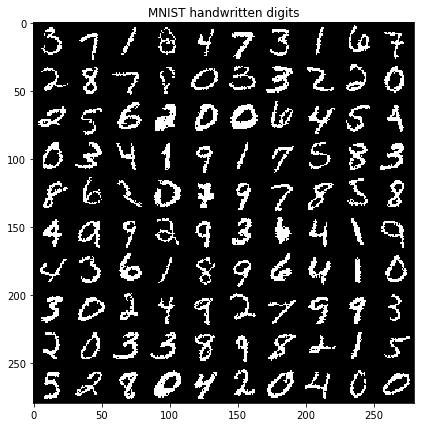

In [3]:
#plot a few MNIST examples
def plot_samples(x,title=''):
    idx = 0
    canvas = np.zeros((28*10, 10*28))
    for i in range(10):
        for j in range(10):
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_train[idx].reshape((28, 28))
            idx += 1
    plt.figure(figsize=(7, 7))
    plt.imshow(canvas, cmap='gray')
    plt.title(title)
    plt.show()

plot_samples(x_train[:100],title='MNIST handwritten digits')

### Building the model
When defining the model the latent layer must act as a bottleneck of information, so that we ensure that we find a strong internal representation. We initialize the VAE with 1 hidden layer in the encoder and decoder using relu units as non-linearity.

In [4]:
from tensorflow import layers
from tensorflow.contrib.layers import fully_connected 
from tensorflow.python.ops.nn import relu, sigmoid, tanh

# Function for sampling from the normal distribution with the 
# reparameterisation trick
def sample_layer(mean, log_var, num_samples = 1, scope='sample_layer'):
    with tf.variable_scope(scope):
        input_shape  = tf.shape(mean)
        batch_size = input_shape[0]
        num_latent = input_shape[1]
        eps = tf.random_normal((batch_size, num_samples, num_latent), 0, 1, dtype=tf.float32)
        
        # Reparameterisation trick: Sample z = mu + sigma*epsilon
        z = tf.expand_dims(mean,1) + tf.multiply(tf.exp(0.5 * tf.expand_dims(log_var, 1)), eps)
        return z

# Error functions    
def sum_of_squared_errors(p, t):
    return tf.reduce_sum(tf.square(p - t), axis=[1])


# computing cross entropy per sample
def categorical_cross_entropy(p, t, eps=1e-10):
    return -tf.reduce_sum(t * tf.log(p+eps), axis=[1])


def binary_cross_entropy(p, t, eps=1e-10):
    return -tf.reduce_sum(t * tf.log(p+eps) + (1-t) * tf.log(1-p+eps), axis=-1)


def kl_normal2_stdnormal(mean, log_var, eps=0.0):
    """
    Compute analytically integrated KL-divergence between a diagonal covariance Gaussian and 
    a standard Gaussian.

    In the setting of the variational autoencoder, when a Gaussian prior and diagonal Gaussian 
    approximate posterior is used, this analytically integrated KL-divergence term yields a lower variance 
    estimate of the likelihood lower bound compared to computing the term by Monte Carlo approximation.

        .. math:: D_{KL}[q_{\phi}(z|x) || p_{\theta}(z)]

    See appendix B of [KINGMA]_ for details.

    Parameters
    ----------
    mean : Tensorflow tensor
        Mean of the diagonal covariance Gaussian.
    log_var : Tensorflow tensor
        Log variance of the diagonal covariance Gaussian.

    Returns
    -------
    Tensorflow tensor
        Element-wise KL-divergence, this has to be summed when the Gaussian distributions are multi-variate.

    References
    ----------
        ..  [KINGMA] Kingma, Diederik P., and Max Welling.
            "Auto-Encoding Variational Bayes."
            arXiv preprint arXiv:1312.6114 (2013).

    """
    return -0.5 * tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=1)


c = - 0.5 * math.log(2*math.pi)
def log_normal2(x, mean, log_var, eps=0.0):
    """
    Compute log pdf of a Gaussian distribution with diagonal covariance, at values x.
    Here variance is parameterized in the log domain, which ensures :math:`\sigma > 0`.

        .. math:: \log p(x) = \log \mathcal{N}(x; \mu, \sigma^2I)
    
    Parameters
    ----------
    x : Tensorflow tensor
        Values at which to evaluate pdf.
    mean : Tensorflow tensor
        Mean of the Gaussian distribution.
    log_var : Tensorflow tensor
        Log variance of the diagonal covariance Gaussian.
    eps : float
        Small number used to avoid NaNs

    Returns
    -------
    Tensorflow tensor
        Element-wise log probability, this has to be summed for multi-variate distributions.
    """
    return tf.reduce_sum(c - log_var/2 - tf.square(x - mean) / (2 * tf.exp(log_var) + eps), axis=[1])

### Layers

In [5]:
# define in/output size
num_features = x_train.shape[1]

# define latent size and number of samples to draw
num_latent_z = 10
num_samples = 3

# Activation function to apply
actfun = sigmoid 

# reset graph
reset_default_graph()

# -- THE MODEL --#
# Input placeholder
x_pl = tf.placeholder(tf.float32, [None, num_features], 'x_pl')

print('x_pl', x_pl.shape)

# Encoder
l_enc = layers.dense(inputs=x_pl, units=128, activation=actfun, name='l_enc')

print('l_enc', l_enc.shape)

## Define the latent parameters as two hidden layers 
#l_mu_q_add = layers.dense(l_enc, units=20, activation=tf.nn.relu)
#l_logvar_q_add = layers.dense(l_enc, units=20, activation=lambda x: tf.clip_by_value(x,-10,10))
l_mu_q = layers.dense(l_enc, units=num_latent_z, activation=None)     #mu(x)
l_logvar_q = layers.dense(l_enc, units=num_latent_z, activation=lambda x: tf.clip_by_value(x,-10,10)) #logvar(x)

print('l_mu_q', l_mu_q.shape)
print('l_logvar_q', l_logvar_q.shape)

# The latent variable sampling layer
l_z = sample_layer(mean=l_mu_q, log_var=l_logvar_q, num_samples=num_samples)

print('l_z', l_z.shape)

# Decoder
l_dec = layers.dense(inputs=l_z, units=128, activation=actfun, name='l_dec')

print('l_dec', l_dec.shape)

# Output layer, sigmoid due to bounded pixel values in range [0,1]
l_out = layers.dense(inputs=l_dec, units=num_features, activation=sigmoid, name='l_out')

print('l_out', l_out.shape)

l_out_mean = tf.reduce_mean(l_out, axis = 1)

print('l_out_mean', l_out_mean.shape)


x_pl (?, 784)
l_enc (?, 128)
l_mu_q (?, 10)
l_logvar_q (?, 10)
l_z (?, 3, 10)
l_dec (?, 3, 128)
l_out (?, 3, 784)
l_out_mean (?, 784)


### Loss

In [6]:
eps = 1e-10

# Loss
# Reconstruction error, log[p(x|z)] in [-\infty, 0]). 
log_p_x_given_z = -tf.reduce_mean(binary_cross_entropy(l_out, tf.expand_dims(x_pl,1), eps=eps), name = "log_p_x_given_z")

# Regularization error: 
# Kulback-Leibler divergence between approximate posterior, q(z|x)
# and prior p(z)=N(z,mu,sigma*I).
KL_qp = tf.reduce_mean(kl_normal2_stdnormal(l_mu_q, l_logvar_q, eps=eps), name = "KL")

# Combining the two terms in the evidence lower bound objective (ELBO)  
ELBO_loss = tf.subtract(log_p_x_given_z, KL_qp, name="ELBO")
#ELBO_loss = tf.subtract(log_p_x_given_z, 0*KL_qp, name="ELBO")

# If you want additional regularization
#reg_scale = 0.0005
#regularize = tf.contrib.layers.l2_regularizer(reg_scale)
#params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
#reg_term = tf.reduce_sum([regularize(param) for param in params])
#loss += reg_term

# define our optimizer
# The Adam optimizer works really well with VAEs.
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.25)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

# Training operator for applying the loss gradients in backpropagation update
# notice minus sign as we want to maximise ELBO
train_op = optimizer.minimize(-ELBO_loss)

In [7]:
# test the forward pass
_x_test = np.zeros(shape=(32, num_features))
# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.85)
# initialize the Session
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))
# test the forward pass
sess.run(tf.global_variables_initializer())
feed_dict = {x_pl: _x_test}
res_forward_pass = sess.run(fetches=[l_out], feed_dict=feed_dict)
print("l_out", res_forward_pass[0].shape)

l_out (32, 3, 784)


### Training

In the training loop we sample each batch and evaluate the error, latent space and reconstructions every epoch.

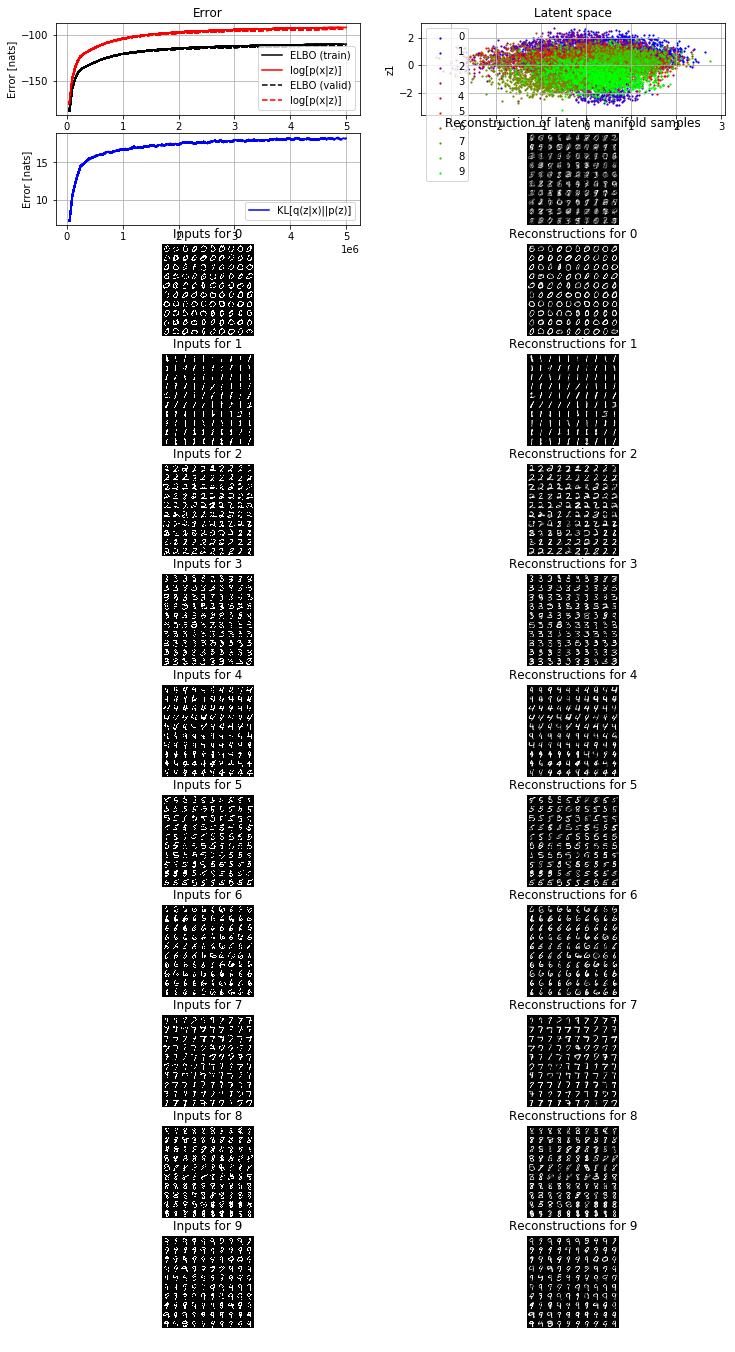

In [8]:
from scipy.stats import norm as gaussian
from sklearn.decomposition import PCA

# Create 
steps = np.linspace(0.1, 0.9, 10)
# 2D gaussian samples -- TODO: Ideally sample from the real p(z)
v = gaussian.ppf(steps)
z = np.zeros((100, num_samples, 2))
i = 0
for z2 in reversed(v):
    for z1 in v:
        z[i,:, 0] = z1
        z[i,:, 1] = z2
        i += 1
z_manifold_samples = z.astype('float32')


batch_size = 100
num_epochs = 100
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size
updates = []

ELBO_train, KL_train, logpxz_train = [],[],[]
ELBO_valid, KL_valid, logpxz_valid = [],[],[]

cur_loss = 0
plt.figure(figsize=(12, 24))

try:
    for epoch in range(num_epochs):
        #Forward->Backprob->Update params
        for i in range(num_batches_train):
            idxs = np.random.choice(range(x_train.shape[0]), size=(batch_size), replace=False)    
            x_batch = x_train[idxs]
            # setup what to fetch, notice l
            fetches_train = [train_op]
            feed_dict_train = {x_pl: x_batch}
            # do the complete backprob pass
            res_train = sess.run(fetches_train, feed_dict_train)

        updates += [batch_size*num_batches_train*(epoch+1)]

        # Evaluate on training set
        fetches_eval = [ELBO_loss, KL_qp, log_p_x_given_z, l_out_mean, l_z, l_mu_q]
        feed_dict_train = {x_pl: x_train}
        res_train = sess.run(fetches_eval, feed_dict_train)
        ELBO_train += [res_train[0]]
        KL_train += [res_train[1]]
        logpxz_train += [res_train[2]]

        # Evaluate on validation set
        feed_dict_valid = {x_pl: x_valid}
        res_valid = sess.run(fetches_eval, feed_dict_valid)
        ELBO_valid += [res_valid[0]]
        KL_valid += [res_valid[1]]
        logpxz_valid += [res_valid[2]]
        eval_out = res_valid[3]
        eval_z = res_valid[-1]
        
        # Evaluate on 100 samples of z, e.g. generate completely new images
        if num_latent_z == 2:
            feed_dict_samples = {l_z: z_manifold_samples}      
        else:  
            z_random_samples = np.random.normal(size=(100, num_samples, num_latent_z)).astype('float32')
            feed_dict_samples = {l_z: z_random_samples}
            
        # Newly generated ex(s)amples
        x_samples = sess.run(l_out_mean, feed_dict_samples)
        
        if epoch == 0:
            continue

        # Plotting
        plt.subplot(num_classes+2,2,1)
        plt.title('Error')
        plt.legend(['ELBO (train)', 'log[p(x|z)]', 'ELBO (valid)', 'log[p(x|z)]'])
        plt.xlabel('Updates'), plt.ylabel('Error [nats]')
        plt.plot(updates, ELBO_train, color="black")
        plt.plot(updates, logpxz_train, color="red")
        plt.plot(updates, ELBO_valid, color="black", linestyle="--")
        plt.plot(updates, logpxz_valid, color="red", linestyle="--")
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        plt.grid('on')
        
        # Latent space visualization (using PCA if dim > 2)
        if num_latent_z != 2:
            pca = PCA(n_components=2)
            pca.fit(eval_z)
            pca.transform(eval_z)
            
        plt.subplot(num_classes+2,2,2)
        plt.cla()
        plt.title('Latent space')
        plt.xlabel('z0'), plt.ylabel('z1')
        color = iter(plt.get_cmap('brg')(np.linspace(0, 1.0, num_classes)))
        legend_handles = []
        for i, c in enumerate(included_classes):
            clr = next(color)
            h = plt.scatter(eval_z[targets_valid==c, 0], eval_z[targets_valid==c, 1], c=clr, s=5., lw=0, marker='o', )
            legend_handles.append(h)
        plt.grid('on')
        plt.legend(legend_handles, included_classes)

        # Plot of KL[q(z|x)|p(z)]
        plt.subplot(num_classes+2,2,3)
        plt.legend(['KL[q(z|x)||p(z)]'])
        plt.ylabel('Error [nats]')
        plt.plot(updates, KL_train, color="blue")
        plt.plot(updates, KL_valid, color="blue", linestyle="--")
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        plt.grid('on')
        
        # Reconstruction of latent manifold samples
        plt.subplot(num_classes+2,2,4)
        plt.cla()
        plt.title('Reconstruction of latent manifold samples')
        plt.axis('off')
        idx = 0
        canvas = np.zeros((28*10, 10*28))
        for i in range(10):
            for j in range(10):
                canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_samples[idx].reshape((28, 28))
                idx += 1
        plt.imshow(canvas, cmap='gray')
        
        c=0
        for k in range(5, 5 + num_classes*2, 2):
            plt.subplot(num_classes+2,2,k)
            plt.cla()
            plt.title('Inputs for %i' % included_classes[c])
            plt.axis('off')
            idx = 0
            canvas = np.zeros((28*10, 10*28))
            for i in range(10):
                for j in range(10):
                    canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_valid[targets_valid==included_classes[c]][idx].reshape((28, 28))
                    idx += 1
            plt.imshow(canvas, cmap='gray')
            
            plt.subplot(num_classes+2,2,k+1)
            plt.cla()
            plt.title('Reconstructions for %i' % included_classes[c])
            plt.axis('off')
            idx = 0
            canvas = np.zeros((28*10, 10*28))
            for i in range(10):
                for j in range(10):
                    canvas[i*28:(i+1)*28, j*28:(j+1)*28] = eval_out[targets_valid==included_classes[c]][idx].reshape((28, 28))
                    idx += 1
            plt.imshow(canvas, cmap='gray')
            c+=1
      
        
        plt.savefig("out53.png")
        display(Image(filename="out53.png"))
        clear_output(wait=True)
        
except KeyboardInterrupt:
    pass
    

# Analyzing the VAE

## Mandatory Exercises

### 1. Expand the model complexity

- Experiment with the number of layers and activation functions in order to improve the reconstructions and latent representation. What solution did you find the best and why?
- Try to increase the number of digit classes in the training set and analyze the learning curves, latent space and reconstructions. For which classes and why does the VAE fail in reconstructing?  *HINT: Try the combination: *included_classes=[0, 1, 4, 9]*, to see how well VAE can separate these digits in the latent representation and reconstructions.*       
- Increase the number of units in the latent layer. Does it increase the models representational power and how can you see and explain this? How does this affect the quality of the reconstructions? *HINT: You can visualize the latent space in 2D by transforming z to a lower dimensional representation with [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) or [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).*


### 1. Answer

For all the relevant exercises below, copies of the figures produced by the training loop for the different models are hosted at https://www.dropbox.com/sh/5p2ihy4np7obd9l/AAAob-7QTqFrijpnuTj8cR24a?dl=0. Feel free to refer to these for the more qualitative differences (e.g. latent manifold reconstructions and reconstructions for the different digits).

The last run performed (and thus what is seen above) is for a larger VAE run on all the digits 0-9. 

#### Number of units in latent layer (or: dimension of latent space)
By increasing the number of units in the latent layer the model's representational power increases.

The first place to look for evidence of this is in the decreasing ELBO error on the validation set. 

| z | validation ELBO |
|-----------------------|
| 2 | -122 |
| 3 | -112 | 
| 6 | -95  | 

Another, more qualitative piece of evidence is found by visual inspection of the reconstructions which have improved quite a bit in quality.

The latent space visualization performed by PCA however, does not incidate much improvement, but this is most likely due to the nature of PCA. If the data is not easily separated by its eigenvectors, then PCA will perform poorly. Antoher choice, given that we have labels, is a discriminant method like Fischer's, but that seems overkill to visualize this during training...

The "best" value of the number of variables for a single layer is hard to decide but a significant improvement is seen going from 2 to 3 while less is seen from 3 to 6. As such 3 seems the better choice.



#### Number of layers
Adding an additional layers defined by 
```
l_mu_q_add = layers.dense(l_enc, units=8, activation=tf.nn.relu)
l_logvar_q_add = layers.dense(l_enc, units=8, activation=lambda x: tf.clip_by_value(x,-10,10))
```
increases the representational power of the VAE. The layer is added as a simple dense layer of 8 units before the "latent layer" so in some sense the added layer just increases the dimension of the latent space. However, it does so in a different manner since it forces the input to the latent space to be abstracted from the orignal image. The resulting validation ELBO is about -122.

Increasing the number of units of the additional layer to 20 results in a validation ELBO of -120. 

It seems that adding additional layers does not have nearly the same effect compared to adding additional latent variables (increasing the dimension of the single hidden latent space layer). This may be due to the presence of the encoder layer which already decreases the 784-dimension inputs to 128-dimensional vectors.


#### Activation functions
For a single latent layer of fixed dimension of 2, different activation functions on the encoder and decoder were also examined 

| encoder activation function | decoder activation function| validation ELBO |
|-----------------------|
| ReLU | ReLU |-122 |
| Tanh | Tanh | -120|
| Sigmoid | Sigmoid | -118 |

There seems to be little practical difference between using specific activation functions. The sigmoid performs margninally better than Tanh and ReLU activations. Other combinations could be tried but they seem to show little promise of improvement.


#### Comments on separation of digits
It is a general trend that some digits are more easily separated in latent space than others. The primary challenge of the examined set of (0,1,4,9) is the separation of 4 and 9 since these are very similar. A few examples of 1s also pose a challenge due to their likeness with 4s and 9s.




### 2. Analyze the purpose of the KL-term.
- How does the KL-term, $KL[q(z|x)||p(z)]$, work as a regulariser on the distributions over latent variables? *HINT: When maximising the ELBO, the probability-distance measure is minimised $KL[q(z|x)||p(z)] \rightarrow 0$ so that $q(z|x) \rightarrow p(z) = \mathcal{N}(z|0,I)$ for all examples, x. At $KL[q(z|x)||p(z)] = 0$ variations in x stops having an affect on the latent distribution and latent units are all described by the same distribution, $\mathcal{N}(z|0,I)$, so they produce a noisy output without signal $z=\epsilon$ to the decoder.* 
- Try removing the KL-term ($KL \cdot 0$) and analyze what happens during training, in the learning curves, latent representation and reconstructions compared to before removing it. 
- Notice what the loss reduces to and explain how this can affect a VAE. *HINT: Compare loss function for AE and VAE, and remember that we can use the pixel-wise binary crossentropy error as the loss in the AEs and for the reconstruction error, $\log p(x|z) = \log Ber(\mu_\phi(z))$, in VAEs.* 





### 2. Answer

#### Kullback-Leibler as regularizer
The Kullback-Leibler divergence works as a regularizer by forcing the approximate posterior $q(z|x)$ to approach the imposed prior on the latent variables  $p(z)=\mathcal{N}(z|0,1)$. That is, the adapted or trained encoder cannot stray too far from the unadapted or untrained encoder. Thus it is, in a sense, regularized.


#### Training without KL-loss
The VAE was trained with single hidden layer with two units (latent variables) but without the KL-term of the loss function. Inspecting the visualization of the latent space, it is clear that removing the KL-term has significantly increased the variance of the samples. 

Including the KL-term forced the samples to have unit variance and a mean close to zero. Now, without the KL-term, the samples have very large variances of around 25 (judging from the visualization). 

This results in the manifold being much less well-defined which is seen from the from the reconstruction of the latent space samples. This shows much less understanding of the different classes of digits than before


#### Reduction of the expression of the loss for VAE without KL-loss

The loss function of the VAE used here is defined as 

$$\mathcal{L}(x) = \mathbb{E}_{q(z|x)} \left[\log p(x|z)\right] - \mathbb{E}_{q(z|x)}\left[\log \frac{q(z|x)}{p(z)}\right] = \mathbb{E}_{q(z|x)} \left[\log p(x|z)\right] - KL[q(z|x) || p(z)]$$

As described above, this consists of a reconstruction loss term and the Kullbach-Leibler divergence term which serves as a regularizer as explained just above. When the KL-term is not included, only the reconstruction error remains in the loss function and 

$$\mathcal{L}(x) =\mathbb{E}_{q(z|x)} \left[\log p(x|z)\right]$$

For this VAE, the ordinary binary cross-entropy loss is used for measuring the reconstruction error such that without hte KL-term, the VAE loss function becomes

$$\mathcal{L}(x) =\mathbb{E}_{q(z|x)} \left[\log p(x|z)\right] = -\sum_{n=1}^N x_n\log \tilde{x}_n + (1-x_n)\log(1-\tilde{x}_n)$$

where $\tilde{x}_n$ is a pixel in the reconstructed output.

This loss function is exactly the same as used for the ordinary autoencoder of lab exercse 1.

Concluding on the answer above, not including the KL-term in the loss function of the VAE results in a unregularized latent variable layer that thus exhibits large variance to learn the features. Restricting the distribution, reduces the variance and increases the quality of the learned features.

### 3. Sampling in the VAE.

- Explain how one could implement multiple samples in the VAE and how that would improve learning. HINT: Look into how the samples are drawn in the sample_layer function
- Experiment with num_samples used when initialising the layers in the VAE. Does it improve the reconstructions and how? 

### 3. Answer

#### Implementing multiple samples in the VAE
A VAE samples from a random node $z$. This is approximated by the parametric model $q(z∣\varphi,x)$ of the true posterior as described in the introduction. The backpropagation algorithm cannot flow through a random node due to its indifferentiabilty. However, introducing a new parameter $\epsilon$ allows a reparameterization of $z$ in a way that allows backprob to flow through the deterministic nodes [1].

Here $q(z∣\varphi,x) = \mathcal{N}(\mu,\sigma^2)$. The reparameterization trick is then used to sample a normal distribution with some specified mean, $\mu$, and variance $\sigma$. The reparameterization trick for the normal distribution simply consists of noting that one can sample $x\sim\mathcal{N}(\mu,\sigma^2)$ by instead sampling $\epsilon\sim\mathcal{N}(0,1)$ and then constructing 

$$x = \mu + \sigma\epsilon$$

That $x\sim\mathcal{N}(\mu,\sigma)$ still holds is readily seen be performing expectations over this construction

\begin{align}
\text{E}[x] &= \text{E}[\mu+\sigma\epsilon]\\
&= \text{E}[\mu] + \text{E}[\sigma\epsilon]\\
&= \mu + \sigma\text{E}[\epsilon]\\
&= \mu
\end{align}

\begin{align}
\text{Var}[x] &= \text{E}[x^2]-\text{E}[x]^2 \\
&= \text{E}[(\mu+\sigma\epsilon)^2]-\text{E}[\mu+\sigma\epsilon]^2 \\
&= \text{E}[\mu^2+\sigma^2\epsilon^2+2\mu\sigma\epsilon]-\mu^2 \\
&= \text{E}[\mu^2]+\sigma^2\text{E}[\epsilon^2]+2\mu\sigma\text{E}[\epsilon]-\mu^2 \\
&= \mu^2+\sigma^2-\mu^2 \\
&= \sigma^2
\end{align}

Thus, the expectation and the mean are the same as in the original Gaussian distribution.

Multiple samples in the VAE are then implemented by sampling not a single but multiple numbers, $\boldsymbol{\epsilon}\sim\mathcal{N}(0,1)$, from the standard normal distribution and then applying the reparameterization trick.



#### Varying the number of samples
As stated in the introduction:

"Feasible approximations of the expectations in the lower bound, $\mathcal{L}(x)$, are obtained by evaluating the inside with samples drawn from the latent distribution, $z \sim q(z|x) = \mathcal{N}(z|\mu_\theta(x), \sigma_\phi(x)I)$ and dividing by the number of samples drawn."


Intuitively speaking, the more samples are drawn from the layer, the better the approximation of the expectations in the lower bound, $\mathcal{L}(x)$.

Experiments were performed with 3, 4, 10 and 15 samples from the layer. Memory allocation errors prevented trying out more samples than 15. However, inspecting the reconstructions and latent space visualization reveal no signficant differences between the number of samples drawn.



[1] https://stats.stackexchange.com/questions/199605/how-does-the-reparameterization-trick-for-vaes-work-and-why-is-it-important

## Optional exercises
- OPT: Look through https://arxiv.org/abs/1509.00519 and explain importance weighted auto-encoders.

- OPT: Implement the importance weighted sampling estimator of the loss.
    
- OPT: Use the original paper http://arxiv.org/pdf/1312.6114v10.pdf or [this blog](http://blog.shakirm.com/2015/10/machine-learning-trick-of-the-day-4-reparameterisation-tricks/) to explain what the reparameterization trick does.

- OPT: The VAE is a probablistic model. We could model $p(x,z,y)$ where $y$ is the label information. Explain how this model could handle semi-supervised learning? You can look through the papers https://arxiv.org/pdf/1406.5298.pdf or  https://arxiv.org/pdf/1602.05473v4.pdf.

### Exercise for Math intuition (Optional, Credits to Charles Blundell)
1. Use Jensen's inequality to show that, if $q(z|x)\neq 0$,
$$
\log p(x) \geq \mathbb{E}_{q(z|x)} \Big [ \log \frac{p(x,z)}{q(z|x)} \Big ]
$$

2. Show that if $\mu_\theta(x)$ and $\sigma_\phi(x)$ are the encoding neural networks with parameters $\theta$ and $\phi$ respectively, taking an input $x$ and

$$
p(z) = \mathcal{N}(z|0,I)\\
q(z|x) = \mathcal{N}(z|\mu_\theta(x), \sigma_\phi(x)I)\\
\mathcal{F}(\theta,\phi) = \mathbb{E}_{q(z|x)} \Big [ \log \frac{p(x|z)p(z)}{q(z|x)} \Big ]
$$

then

$$
\mathcal{F}(\theta,\phi) = \mathbb{E}_{\mathcal{N}(\epsilon|0,I)} \Big [ \log \frac{p(x|z)p(z)}{q(z|x)} \Big ] \\
z = \mu_\theta(x) + \sigma_\phi(x) \cdot \epsilon \\
\frac{\partial z}{\partial \theta} = \frac{\partial \mu_\theta(x)}{\partial \theta} \\
\frac{\partial z}{\partial \phi} = \frac{\partial \sigma_\phi(x)}{\partial \phi} \cdot \epsilon
$$

### The tradeoff connection between the lower bound and KL-divergence
To understand this tradeoff connection, we flip the whole problem around into the perspective of the KL-divergence

$KL[q(z|x) || p(z|x)] = \int_z q(z|x)\log \frac{q(z|x)}{p(z|x)}dz = \mathbb{E}_{q(z|x)}\left[\log \frac{q(z|x)}{p(z|x)}\right]$,

which is a non-negative distance measure between distributions, so by minimising it wrt. to the parameters in $q(z|x)$, the distribution moves close to our unknown $p(z|x)$. But as $p(z|x)$ is unknown and would include some rather intractable integrals over neural networks, we can instead get rid of it by expressing it through Bayes rule $p(z|x) = p(x|z)p(z)/p(x)$ and thereby decompose the KL-divergence into our log-likelihood and lower bound:

$ KL[q(z|x) || p(z|x)] = \int_z q(z|x)\log \frac{q(z|x)p(x)}{p(x|z)p(z)}dz = \int_z q(z|x)\log \frac{q(z|x)}{p(x|z)p(z)}dz + \log p(x)$ 

by seeing that the likelihood, $p(x)$, is independent of $z$ and pull it out of the integral. We can flip the sign and fraction in the integral term to recognise it as the negative lower bound

$KL[q(z|x) || p(z|x)] = - \int_z q(z|x)\log \frac{p(x|z)p(z)}{q(z|x)}dz + \log p(x) =  -\mathcal{L}(x) + \log p(x)$

We then find the log-likelihood to consist of the two terms and hold the inequality

$\log p(x) =  KL[q(z|x) || p(z|x)] + \mathcal{L}(x) \geq \mathcal{L}(x)$

where the KL-divergence is non-zero and the log-likelihood is $\log p(x) \leq 0$. This means that maximising the lower bound from the negative domain towards $0$ will also maximise the log-likelihood, while pushing down the KL-divergence until $q(z|x)$ cannot move closer to natures true distribution, $p(z|x)$. So how close the lower bound can get to the log-likelihood is dependent on the flexibility of the distribution we choose for $q(z|x)$. 

# Exercise from Nielsen

## Problem
The chose problem is from chapter 3:

Verify that the standard deviation of $z=\sum_j w_jx_j+b$ in the paragraph above is $\sqrt{\frac{3}{2}}$.

In the paragraph above we are told that the weights are initialized as random variables of a Gaussian distribution with zero mean and a variance of $\sigma^2 =1/n_{\text{in}}$ where $n_\text{in}$ is the number of inputs to the neuron in question. 

The bias is initialized as a random variable of zero mean and unit variance Gaussian. 

We have $n_\text{in}=1000$ inputs, 500 of which are 1 and 500 of which are 0.

## Solution

From the problem we have 

$$ \text{Var}[w_j] = \frac{1}{1000} $$

$$ \text{Var}[b] = 1 $$


The variance of a discrete random variable can generally be written as

\begin{align}
\text{Var}[x] = \sum_j p(x_j) (x_j-\mu)^2 
\end{align}

where $p(x)$is the pdf of the generating distribution and $\mu$ is the mean of that distribution.

Let $x=(x_1,x_2,\dots,x_{n_\text{in}}) = (x_1,x_2,\dots,x_{1000})$ be the inputs given by the problem. In this case, the values $x_j$ can be assumed to be eqally likely to be 0 or 1, as out of a thousand, 500 are 1 and 500 are 0. In this case, the variance can be written as

\begin{align}
\text{Var}[x] = \frac{1}{n_\text{in}}\sum_j^{n_\text{in}} (x_j-\mu)^2 
\end{align}

Clearly $\mathbb{E}[x] = \mu = 0.5$. From this, the variance of $x$ is computed

\begin{align}
\text{Var}[x] &= \frac{1}{n_\text{in}}\sum_j^{n_\text{in}} (x_j-\mu)^2\\
&= \frac{1}{1000}\left( 5000\cdot(0-0.5)^2+500\cdot(1-0.5)^2 \right)\\
&= \frac{1}{2}
\end{align}

Now, the variance of the weighted input to the unit can be computed using the properties of the variance operator.

\begin{align}
\text{Var}[z] &= \text{Var}\left[ \sum_j^{n_\text{in}} w_jx_j + b \right]\\
&= \sum_j^{n_\text{in}} \text{Var}[w_jx_j +b]\\
&= \sum_j^{n_\text{in}} \text{Var}[w_jx_j] + \text{Var}[b]\\
&= \text{Var}[b] + \sum_j^{n_\text{in}} \text{Var}[w_j]\text{Var}[x_j]\\
&= 1 + \sum_j^{n_\text{in}} \frac{1}{1000}\frac{1}{2}\\
&= 1 + 1000\cdot\frac{1}{1000}\frac{1}{2}\\
&= \frac{3}{2}
\end{align}

Thus, the variance of the weighted input is $3/2$.

